In [ ]:
## IMPORTING ALL THE LIBRARIES WE CARE ABOUT

import euclidemu2
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
import pandas as pd
import os
from scipy.stats import qmc
import scipy
from scipy.linalg import eigh
import torch
from sbi.inference import NLE
import emcee
from getdist import plots, MCSamples

working_dir = os.path.dirname(os.getcwd())
ee2=euclidemu2.PyEuclidEmulator()



In [142]:
param_names = [f"theta_{i+1}" for i in range(n_params)]
param_labels = [rf"\theta_{i+1}" for i in range(n_params)]
truth_marker = dict(zip(param_names, [truth[i] for i in range(n_params)]))



NameError: name 'truth' is not defined

In [ ]:
SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 14


# Code for figure 9 of the paper, useful visualization of the compressed data vector without performing the SBI
def makeplot(PCC, method):
    
    PCC1 = PCC[:16,:16]
    PCC2 = PCC[:16,16:]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), gridspec_kw={'hspace': 0},constrained_layout=True)
    fig.suptitle(r"$\|(\rho_{c})^{\ }_{ij}\|$ and $\|(\rho_{cp})^{\ }_{i\alpha}\|$ for WL2 with "+method, fontsize = BIGGER_SIZE, y=0.96)

    ax1.imshow(PCC1, vmin = 0, vmax = 1)
    ax1.vlines(0 + 5-0.5, ymin = -0.5, ymax = 15.5, color = 'red', ls = 'dotted')
    ax1.hlines(0 + 5-0.5, xmin = -0.5, xmax = 15.5, color = 'red', ls = 'dotted')
    ax1.set_yticks((0,4,5,15), (0,4,5,15), fontsize = SMALL_SIZE)
    ax1.set_xticks((0,4,5,15), (0,4,5,15), fontsize = SMALL_SIZE)
    ax1.set_ylabel(r"$c$ Vector Index $i$", fontsize = MEDIUM_SIZE, labelpad=0)
    ax1.set_xlabel(r"$c$ Vector Index $j$", fontsize = MEDIUM_SIZE, labelpad=0)
    ax1.text( 11.8, 1,r"$\|(\rho_{c})^{\ }_{ij}\|$", color='black', 
            bbox=dict(facecolor='white', edgecolor='black'), fontsize = MEDIUM_SIZE)


    im = ax2.imshow(PCC2, vmin = 0, vmax = 1)
    ax2.vlines(0 + 5-0.5, ymin = -0.5, ymax = 15.5, color = 'red', ls = 'dotted')
    ax2.hlines(0 + 5-0.5, xmin = -0.5, xmax = 15.5, color = 'red', ls = 'dotted')
    ax2.set_xticks((0,1,2,3,4,  5, 6,7,  9.5, 13.5), ( r'$S_8$', r'$\Omega_m$', r'$w_0$', r'$A_{\rm IA}$', r'$\eta_{\rm IA}$', r'$n_s$', r'$h$', r'$\Omega_b$', r'$m_i$', r'$\bar{n}_i$'), rotation=90, fontsize = SMALL_SIZE)
    ax2.set_yticks((), ())
    ax2.set_xlabel(r"$p_\alpha$", fontsize = MEDIUM_SIZE)
    ax2.text( 11.2, 1,r"$\|(\rho_{cp})^{\ }_{i\alpha}\|$", color='black', 
            bbox=dict(facecolor='white', edgecolor='black'), fontsize = MEDIUM_SIZE)

    fig.colorbar(im, fraction=0.05, pad=0.03)
    plt.show()

In [ ]:


def run_mcmc(
    nchains, nparams, ln_posterior, mock_simulator, data, inv_cov, prior, samples_per_chain, nburn, 
):
    pos = prior.rvs(nchains)

    sampler = emcee.EnsembleSampler(
        nwalkers=nchains,
        ndim=nparams,
        log_prob_fn=ln_posterior,
        vectorize=True,
        # moves=emcee.moves.StretchMove(),
        args=[mock_simulator, data, inv_cov, prior],
    )

    sampler.run_mcmc(pos, samples_per_chain, progress=True)

    samples = np.ascontiguousarray(sampler.chain[:, nburn:, :])
    log_prob = np.ascontiguousarray(sampler.lnprobability[:, nburn:])
    flat_samples, flat_weights = np.unique(
        sampler.get_chain(flat=True), axis=0, return_counts=True
    )
    flat_log_prob, _ = np.unique(
        sampler.get_log_prob(flat=True), axis=0, return_counts=True
    )

    samples = np.ascontiguousarray(sampler.chain[:, nburn:, :])
    log_prob = np.ascontiguousarray(sampler.lnprobability[:, nburn:])

    return flat_samples, flat_weights, flat_log_prob, samples, log_prob



In [ ]:
def init_cov(ndim):
    """Initialise random non-diagonal covariance matrix.

    Args:

        ndim: Dimension of Gaussian.

    Returns:

        cov: Covariance matrix of shape (ndim,ndim).

    """

    cov = np.zeros((ndim, ndim))
    diag_cov = np.ones(ndim) + np.random.randn(ndim) * 0.1
    np.fill_diagonal(cov, diag_cov)
    off_diag_size = 0.5
    for i in range(ndim - 1):
        cov[i, i + 1] = (
            (-1) ** i * off_diag_size * np.sqrt(cov[i, i] * cov[i + 1, i + 1])
        )
        cov[i + 1, i] = cov[i, i + 1]

    return cov

In [ ]:
## SET UP LHS

def make_LHS(dim,num, lower_bound,upper_bound):

    sampler = qmc.LatinHypercube(d=dim)
    sample = sampler.random(n=num)

    new_sample = sample.copy().T
    for i in range(len(new_sample)):
        new_sample[i] = new_sample[i] * (upper_bound[i] - lower_bound[i]) + lower_bound[i]
    return new_sample
# 0.04 <= Omg_b <= 0.06      0
# 0.24 <= Omega_m <= 0.4     1
# 0.0 <= mnu <= 0.15         2
# 0.92 <= n_s <= 1.0         3
#0.61 <= h <= 0.73           4
# -1.3 <= w0 < -0.7          5
# -0.7 <= wa <= 0.7          6
# 1.7 <= A_s1e9 <= 2.5       7

#sample = make_LHS(4,1000, [0.24,0.8,1.7e-9,0.5],[0.4,1.2,2.5e-9,0.9])
lowerbounds = [0.04,0.24,0.0,0.92,0.61,-1.3,-0.7,1.7e-9]
upperbounds = [0.06,0.4,0.15,1.0,0.73,-0.7,0.5,2.5e-9]
sample = make_LHS(8,1000, lowerbounds, upperbounds)

np.save(working_dir + '/AstroDat/Data/First_dataset_sample.npy',  sample)


print(sample.shape)
print(sample[0,15])


(8, 1000)
0.04673708182947928


In [ ]:
# initialize example
cosmo_par_test = {'As':sample[7,0], 'ns':sample[3,0], 'Omb':sample[0,0],'Omm':sample[1,0],'h':sample[4,0],'mnu':sample[2,0],'w':sample[5,0],'wa':sample[6,0]}
k, pnl, plin, b = ee2.get_pnonlin(cosmo_par_test, [0.0])


In [ ]:

def make_PkNL_from_sample(sample):
    
    Pk = np.zeros((len(sample[0]),613))
    for i in range(len(sample[0])):
        cosmo_par={'As':sample[7,i], 'ns':sample[3,i], 'Omb':sample[0,i],'Omm':sample[1,i],'h':sample[4,i],'mnu':sample[2,i],'w':sample[5,i],'wa':sample[6,i]}
        redshifts=[0]
        k, pnl, plin, b = ee2.get_pnonlin(cosmo_par, redshifts)
        Pk[i] = pnl[0]
    return Pk

def make_BkNL_from_sample(sample):
    
    Pk = np.zeros((len(sample[0]),613))
    for i in range(len(sample[0])):
        cosmo_par={'As':sample[7,i], 'ns':sample[3,i], 'Omb':sample[0,i],'Omm':sample[1,i],'h':sample[4,i],'mnu':sample[2,i],'w':sample[5,i],'wa':sample[6,i]}
        redshifts=[0]
        k, Bnl = ee2.get_boost(cosmo_par, redshifts)
        Pk[i] = Bnl[0]
    return Pk

#Pk_ccl = make_PkNL_from_sample(sample)
#np.save(working_dir + '/AstroDat/Data/First_dataset_PkNL.npy',  Pk_ccl)

#np.save(working_dir + '/AstroDat/Data/First_dataset_BkNL.npy',  Nk_ccl)

#print(make_PkNL_from_sample(sample[:,0].reshape(8,1)))


In [ ]:
## Power spectrum from CCL
"""
Pk_ccl = np.zeros((len(sample[0]),120))

## Linear Power spectra
for i in range(len(sample[0])):
    
    wb = 0.0223
    wr = 0.0
    
    ns = sample[1]
    As = sample[2]
    h = sample[3]
    wm = sample[0]*h**2

    kk_ccl = np.logspace(-3,1,len(Pk_ccl[0]))*h[i]               # in 1/Mpc
    cosmoLCDM = ccl.Cosmology(Omega_c=(wm[i] - wb)/h[i]**2,
                               Omega_b=wb/h[i]**2, 
                               A_s=As[i], 
                               h = h[i],
                               n_s=ns[i],
                               Omega_k=0)

    Pk_0 = ccl.power.nonlin_matter_power(cosmoLCDM, kk_ccl, 1)    # in (Mpc)^3

    Pk_ccl[i] = Pk_0*h[i]**3    # in (Mpc)^3/h^3

    kk_ccl = kk_ccl/h[i]    # in h/Mpc
    if i%10 == 0:
        print(i)
"""


'\nPk_ccl = np.zeros((len(sample[0]),120))\n\n## Linear Power spectra\nfor i in range(len(sample[0])):\n\n    wb = 0.0223\n    wr = 0.0\n\n    ns = sample[1]\n    As = sample[2]\n    h = sample[3]\n    wm = sample[0]*h**2\n\n    kk_ccl = np.logspace(-3,1,len(Pk_ccl[0]))*h[i]               # in 1/Mpc\n    cosmoLCDM = ccl.Cosmology(Omega_c=(wm[i] - wb)/h[i]**2,\n                               Omega_b=wb/h[i]**2, \n                               A_s=As[i], \n                               h = h[i],\n                               n_s=ns[i],\n                               Omega_k=0)\n\n    Pk_0 = ccl.power.nonlin_matter_power(cosmoLCDM, kk_ccl, 1)    # in (Mpc)^3\n\n    Pk_ccl[i] = Pk_0*h[i]**3    # in (Mpc)^3/h^3\n\n    kk_ccl = kk_ccl/h[i]    # in h/Mpc\n    if i%10 == 0:\n        print(i)\n'

In [ ]:
#np.savetxt(working_dir + '/AstroDat/Data/First_dataset_PkNL.dat', np.array([kk_ccl, Pk_ccl]).T)

#Pk_ccl = np.load(working_dir + '/AstroDat/Data/First_dataset_PkNL.npy')
Bk_ccl = np.load(working_dir + '/AstroDat/Data/First_dataset_BkNL.npy')
sample = np.load(working_dir + '/AstroDat/Data/First_dataset_sample.npy')

print(Bk_ccl.shape)
print(sample.shape)

(1000, 613)
(8, 1000)


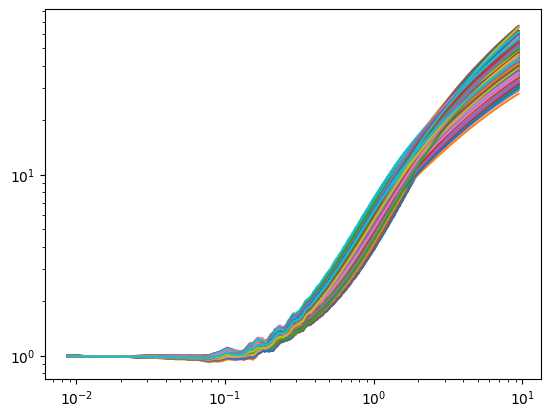

In [ ]:
for i in range(len(sample[0])):
    plt.loglog(k,Bk_ccl[i])

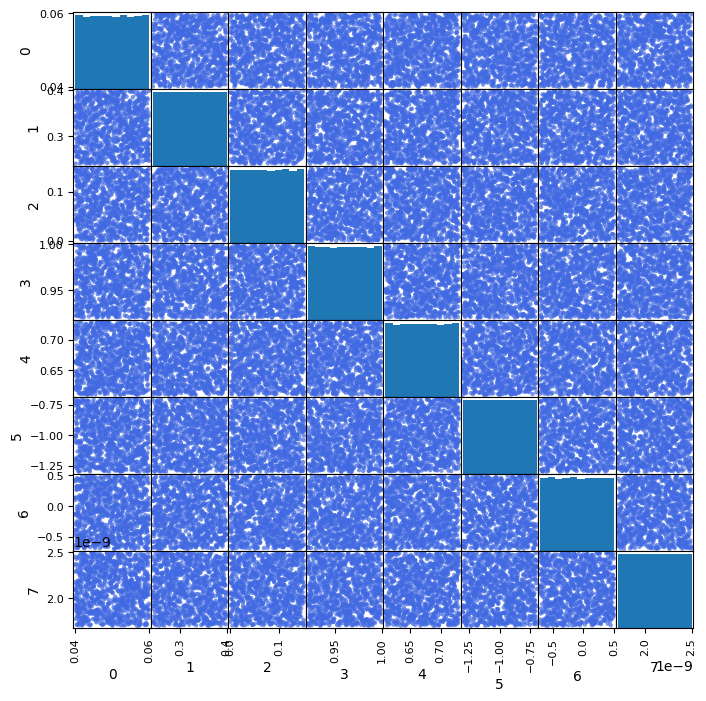

In [ ]:
df_theta_emu = pd.DataFrame(sample.T)

# Customization options
color_emu = "royalblue"   # Color for df_theta_emu
color_val = "crimson"     # Color for df_theta_val
s = 10                    # Marker size
tick_size = 12            # Tick label size
label_size = 14           # Axis label size
tick_rotation = 45        # Rotation angle for tick labels
diag_color = "black"      # Color for diagonal histograms/KDE

# Create scatter matrix for the first dataset
scatter_matrix_fig = pd.plotting.scatter_matrix(
    df_theta_emu, 
    figsize=(8, 8), 
    color=color_emu, 
    marker='o', 
    s=s, 
    alpha=0.7,
    density_kwds={'color': diag_color, 'linewidth': 2},
)


(621, 621)
(613, 613)
5.989707088378475e+20
(8,)
(613, 8)


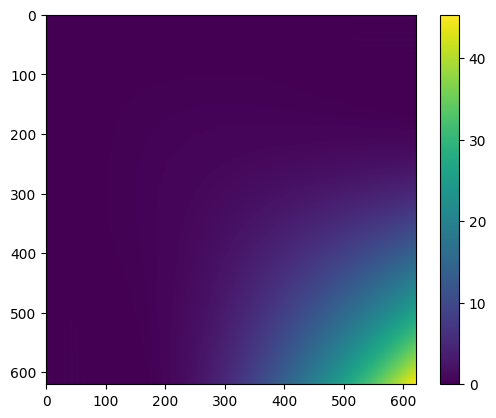

In [ ]:
### TRY CCA
# CCA weighs by correlation rather than eigenvalues

n_params = 8
cca_cov = np.cov(sample,Bk_ccl.T)
cp = cca_cov[:n_params,:n_params] # parameter cov
cd = cca_cov[n_params:,n_params:] # data cov
cpd = cca_cov[:n_params,n_params:] # parameter-data cross cov
plt.imshow((np.abs(cca_cov)), vmin=np.min((np.abs(cca_cov))), vmax=np.max((np.abs(cca_cov))))
plt.colorbar()
# This 'cl' can be understood as the projection of 'cp' to data vector space
# you're projecting your parameter correlation onto your cross-correlation basis
cl = cpd.T@np.linalg.inv(cp)@cpd

print(cca_cov.shape)
print(cd.shape)

print(np.linalg.cond(cd -cl))

# As seen in the paper, this generalized eigenvalue problem is equivalent to CCA
# but is more numerical stable as 'cd' and 'cd-cl' are both invertible.
# This problem is motivated as mutual information maximization under Gaussian linear model assumptions
evals, evecs = eigh(cd, (cd - cl) + 1e-10*np.eye((cd - cl).shape[0]))

# In the context of the CCA, only min( dim(param), dim(data vector) ) components are real and the rest are noise. 
evals = evals[::-1][:n_params]
evecs = evecs[:,::-1][:,:n_params]


print(evals.shape)
print(evecs.shape)


(613, 8)
(1000, 613)
(8, 1000)
(613, 1000)


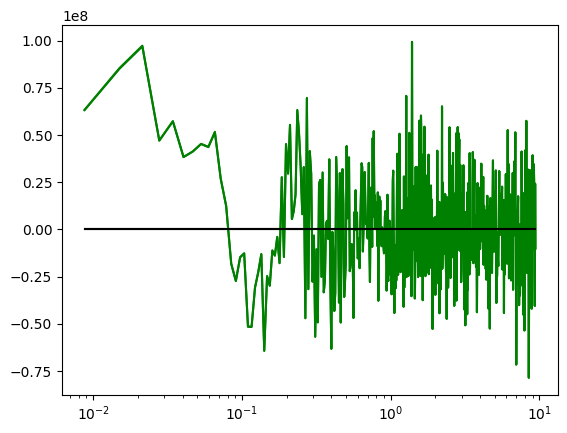

In [ ]:
print(evecs.shape)
print(Bk_ccl.shape)

compressed_data = evecs.T@Bk_ccl.T

uncompressed_data = ((evecs@compressed_data))

print(compressed_data.shape)
print(uncompressed_data.shape)

for i in range(2):
    plt.semilogx(k,uncompressed_data.T[i],"g")
    plt.semilogx(k,Bk_ccl[i],"k")

In [ ]:
def init_cov(ndim):
    """Initialise random non-diagonal covariance matrix.

    Args:

        ndim: Dimension of Gaussian.

    Returns:

        cov: Covariance matrix of shape (ndim,ndim).

    """

    cov = np.zeros((ndim, ndim))
    #diag_cov = 0.01*np.ones(ndim) + np.random.randn(ndim) * 0.001
    diag_cov = 1*np.ones(ndim) + np.random.randn(ndim) * 0.1
    np.fill_diagonal(cov, diag_cov)
    off_diag_size = 0.5
    for i in range(ndim - 1):
        cov[i, i + 1] = (
            (-1) ** i * off_diag_size * np.sqrt(cov[i, i] * cov[i + 1, i + 1])
        )
        cov[i + 1, i] = cov[i, i + 1]

    return cov

cov = init_cov(len(k))


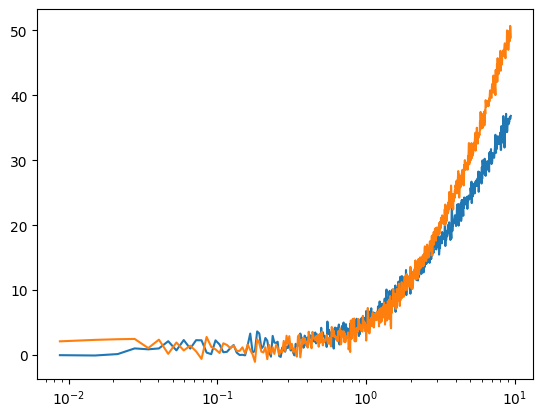

In [ ]:
for i in range(2):
    Bknoisy = np.random.multivariate_normal(Bk_ccl[i], cov)
    plt.semilogx(k, Bknoisy)

In [ ]:
num_sims = 1000
num_rounds = 3
prior_torch = torch.distributions.uniform.Uniform(torch.tensor(lowerbounds), torch.tensor(upperbounds))

inference = NLE(prior_torch)

proposal = prior_torch

"""
theta = torch.tensor(sample.T, dtype=torch.float32)
noiseless_x = torch.tensor(np.log10(Pk_ccl), dtype=torch.float32)
x = np.zeros((noiseless_x.shape[0], noiseless_x.shape[1]))
for i in range(noiseless_x.shape[0]):
    x[i] = np.random.multivariate_normal(noiseless_x[i], cov)
compressed_x = x@evecs
compressed_x = torch.tensor(compressed_x, dtype=torch.float32)
print(compressed_x)
_ = inference.append_simulations(theta, compressed_x).train()
posterior = inference.build_posterior().set_default_x(torch.tensor(sample.T[0], dtype=torch.float32))
proposal = posterior

"""
for j in range(num_rounds):
    if j == 0:
        theta = torch.tensor(sample.T, dtype=torch.float32)
        noiseless_x = torch.tensor(Bk_ccl, dtype=torch.float32)
        print("0", theta.shape)
        x = np.zeros((noiseless_x.shape[0], noiseless_x.shape[1]))
        for i in range(noiseless_x.shape[0]):
            x[i] = np.random.multivariate_normal(noiseless_x[i], cov)
        compressed_x = x@evecs
        compressed_x = torch.tensor(compressed_x, dtype=torch.float32)
        print(f"Round {j}: theta {theta.shape}, compressed_x {compressed_x.shape}")
        _ = inference.append_simulations(theta.T, compressed_x.T).train()
        posterior = inference.build_posterior().set_default_x(torch.tensor(sample.T[0], dtype=torch.float32))
        proposal = posterior
    else:
        theta = proposal.sample((num_sims,8))
        noiseless_x = torch.tensor(make_BkNL_from_sample(theta.detach().numpy()))
        print(theta.shape)
        x = np.zeros((noiseless_x.shape[0], noiseless_x.shape[1]))
        for i in range(noiseless_x.shape[0]):
            x[i] = np.random.multivariate_normal(noiseless_x[i], cov)
        compressed_x = x@evecs
        compressed_x = torch.tensor(compressed_x, dtype=torch.float32)
        _ = inference.append_simulations(theta, compressed_x).train()
        posterior = inference.build_posterior().set_default_x(torch.tensor(sample.T[0], dtype=torch.float32))
        proposal = posterior



0 torch.Size([1000, 8])


/tmp/ipykernel_194023/1666663385.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x[i] = np.random.multivariate_normal(noiseless_x[i], cov)


In [180]:
print(proposal.sample((2000,8)))

RuntimeError: The size of tensor a (10000) must match the size of tensor b (8) at non-singleton dimension 1

In [ ]:
nle_posterior_theta = posterior.sample((2000,8), x=torch.tensor(sample.T[0], dtype=torch.float32), num_chains=100)
nle_posterior_samples = nle_posterior_theta.detach().numpy()
nle_posterior_log_probs = posterior.potential(nle_posterior_theta.detach(), x=torch.tensor(torch.tensor(sample.T[0], dtype=torch.float32), dtype=torch.float32)).numpy()

super_nle_samples = MCSamples(
    samples=nle_posterior_samples,
    names=param_names,
    labels=param_labels,
    label="Super SBI model",
    sampler="mcmc",
)

AttributeError: 'Uniform' object has no attribute 'potential'

In [ ]:
triangle_plot(
    [super_nle_samples],
    truth=truth_marker)

torch.Size([1000, 8])


In [ ]:

# Create torch distribution
prior_torch = torch.distributions.uniform.Uniform(torch.tensor(lowerbounds), torch.tensor(upperbounds))

num_sims = 2000
num_rounds = 3
inference = NLE(prior = prior_torch)
proposal = torch.tensor(compressed_data, dtype=torch.float32)

for _ in range(num_rounds):
    theta = torch.tensor(sample, dtype=torch.float32)
    compressed_x = torch.tensor(compressed_data, dtype=torch.float32)
    print(compressed_x.isnan().any())
    _ = inference.append_simulations(theta, compressed_x).train()
    posterior = inference.build_posterior().set_default_x(torch.tensor(compressed_data, dtype=torch.float32))
    proposal = posterior




tensor(False)


ImportError: cannot import name 'skip_code' from 'torch._C._dynamo.eval_frame' (unknown location)

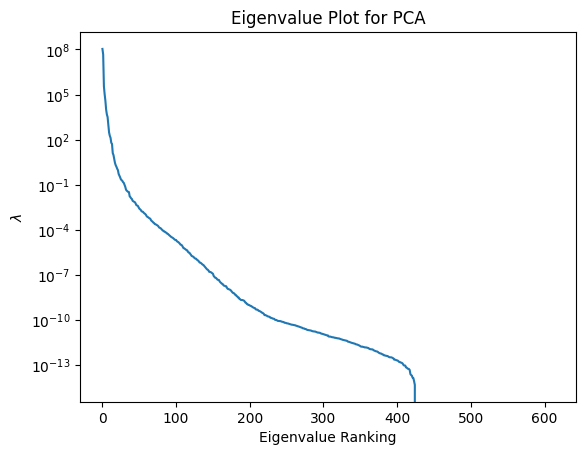

NameError: name 'dv_LFI' is not defined

In [ ]:
# Compute the covariance matrix
cov = np.cov(Pk_ccl.T)

# np's eigh returns lambda and vectors in increasing order of lambda
evals, evecs = np.linalg.eigh(cov)
evals = evals[::-1]
evecs = evecs[:,::-1]

plt.title("Eigenvalue Plot for PCA")
plt.xlabel("Eigenvalue Ranking")
plt.ylabel(r"$\lambda$")
plt.plot(evals)
plt.yscale('log')
plt.show()

# compress to 16 components like other methods
evecs = evecs[:,:16]

# compression is a linear operation
compressed_dv   =  np.array((dv_LFI)@evecs)

PCC = np.abs(np.corrcoef( compressed_dv,pars_LFI, rowvar = False))
makeplot(PCC, 'PCA')

In [ ]:
# use As1e9
pars_train = sample.T.copy()   
pars_train[:,2] = pars_train[:,2]*1e9

print(pars_train.shape)
print(Pk_ccl.shape)

# Compute the sampled parameter auto covariance, simulated data vector auto covariance
# and the parameter-data vector cross covariance
cov = np.cov(pars_train.T, Pk_ccl.T)
cp = cov[:4,:4]
cd = cov[4:,4:]
cpd = cov[:4,4:]

# This 'cl' can be understood as the projection of 'cp' to data vector space
cl = cpd.T@np.linalg.inv(cp)@cpd

# As seen in the paper, this generalized eigenvalue problem is equivalent to CCA
# but is more numerical stable as 'cd' and 'cd-cl' are both invertible.
# This problem is motivated as mutual information maximization under Gaussian linear model assumptions
evals, evecs = scipy.linalg.eigh(cd, cd - cl)

# In the context of the CCA, only min( dim(param), dim(data vector) ) components are real and the rest are noise. 
evals = evals[::-1][:4]
evecs = evecs[:,::-1][:,:4]

plt.title("Mutual Information Plot for CCA")
plt.xlabel("Compressed Data Vector (CDV) Index")
plt.ylabel("Mutual Information Between Parameter and CDV")
plt.plot(np.log(evals)/2)
plt.show()

compressed_dv = dv_LFI@evecs

PCC = np.abs(np.corrcoef( compressed_dv,pars_LFI, rowvar = False))
makeplot(PCC, 'CCA')

(1000, 4)
(1000, 120)


LinAlgError: The leading minor of order 23 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.